In [66]:
%matplotlib inline

import wandb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sky_spot.utils import ClusterType

api = wandb.Api()
plt.rc('font', size=16)
entity, project = "michaelvll", "sky-spot"  # set to your entity and project 
runs = api.runs(entity + "/" + project) 
print(len(runs))


194


In [57]:

# TAGS = ['baseline']
TAGS = []
NOT_TAGS = ['hidden']
DDLS = {20, 20.4, 23, 24}
STRATEGIES = ['strawman']

def filter_runs(tags, ddls, strategies, task_durations=[20], trace_names=['1.json']):
    filters = {
        'env_metadata': lambda x: x['name'] == 'trace' and 'trace_file' in x and any(name in x['trace_file'] for name in trace_names),
        'strategy_metadata': lambda x: x['name'] in strategies,
        'task_duration_hours': lambda x: x in task_durations,
        'deadline_hours': lambda x: ddls is None or x in ddls,
    }


    def filter_run(run):
        return all([f(run.config[k]) for k, f in filters.items()])


    run_dfs = []
    new_runs = []
    for run in runs:
        for tag in tags:
            if tag not in run.tags:
                break
        else:
            # all tags found
            for not_tag in NOT_TAGS:
                if not_tag in run.tags:
                    break
            else:
                df = run.history()
                df['Task/Remaining(hours)'] = df['Task/Remaining(seconds)'] / 3600
                if filter_run(run):
                    run_dfs.append((run, df))
    return sorted(run_dfs, key=lambda x: x[0].config['deadline_hours'], reverse=True)


In [3]:
run_dfs = filter_runs(TAGS, DDLS, STRATEGIES)


In [4]:
LINE_STYLES = ['--', ':', '-.', ':']
cmap = plt.get_cmap("tab10")
def plot_y(run_dfs, y_name='ClusterType', is_step_plot=True, separate_ax=False):
    if separate_ax:
        fig, ax = plt.subplots(len(run_dfs))
    else:
        fig, ax = plt.subplots()
        ax = [ax] * len(run_dfs)
    strategy, task_duration = None, None
    for i, (run, df) in enumerate(run_dfs):
        label = run.config['deadline_hours']
        label=f'ddl={label}'
        drawstyle = 'steps-pre' if is_step_plot else None
        linestyle = LINE_STYLES[i%len(LINE_STYLES)] if not separate_ax else '-'
        sns.lineplot(x=df['Elapsed'] / 3600, y=df[y_name], label=label, 
                    linestyle=linestyle, color=cmap(i), drawstyle=drawstyle, ax=ax[i])
        
        if separate_ax:
            ax[i].set_title(label)
            ax[i].legend().remove()
    if not separate_ax:
        ax[0].legend(loc='best')
    return fig, ax

## Strawman Strategy

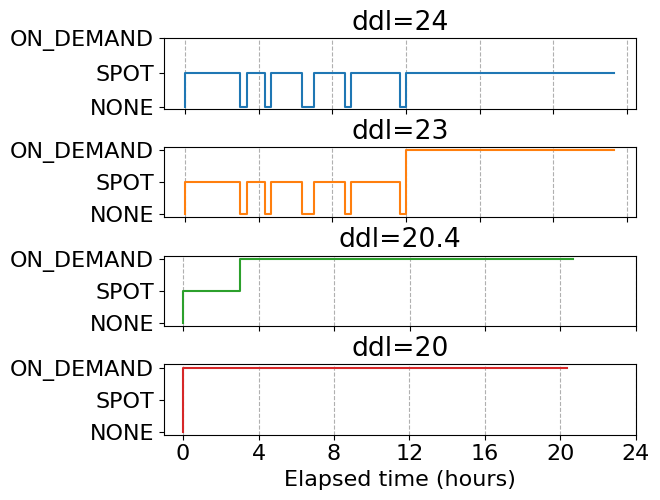

In [5]:
fig, ax = plot_y(run_dfs, y_name='ClusterType', separate_ax=True)
for x in ax:
    x.set_yticks([1, 2, 3])
    x.set_yticklabels([ClusterType(i).name for i in [1, 2, 3]])
    x.set_ylabel('')
    #  ax.set_title(f'')
    x.set_xticks(list(range(0, 25, 4)))
    x.grid(True, which='major', axis='x', linestyle='--')
    x.set_xticklabels([''] * 7)
    x.set_xlabel('')
ax[-1].set_xlabel('Elapsed time (hours)')
ax[-1].set_xticklabels(list(range(0, 25, 4)))
fig.tight_layout(pad=0)

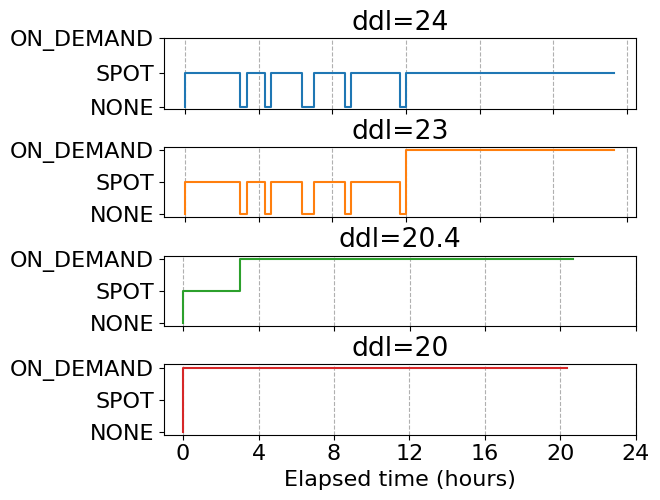

In [6]:
fig, ax = plot_y(run_dfs, y_name='RequestType', separate_ax=True)
for x in ax:
    x.set_yticks([1, 2, 3])
    x.set_yticklabels([ClusterType(i).name for i in [1, 2, 3]])
    x.set_ylabel('')
    #  ax.set_title(f'')
    x.set_xticks(list(range(0, 25, 4)))
    x.grid(True, which='major', axis='x', linestyle='--')
    x.set_xticklabels([''] * 7)
    x.set_xlabel('')
ax[-1].set_xlabel('Elapsed time (hours)')
ax[-1].set_xticklabels(list(range(0, 25, 4)))
fig.tight_layout(pad=0)

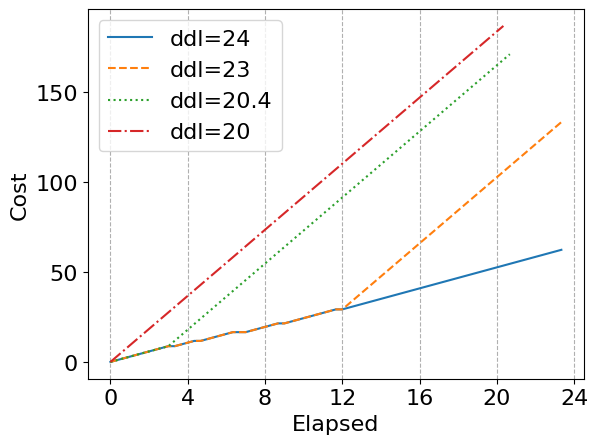

In [7]:
fig, ax = plot_y(run_dfs, y_name='Cost', is_step_plot=False)
ax[0].set_xticks(list(range(0, 25, 4)))
ax[0].grid(True, which='major', axis='x', linestyle='--')

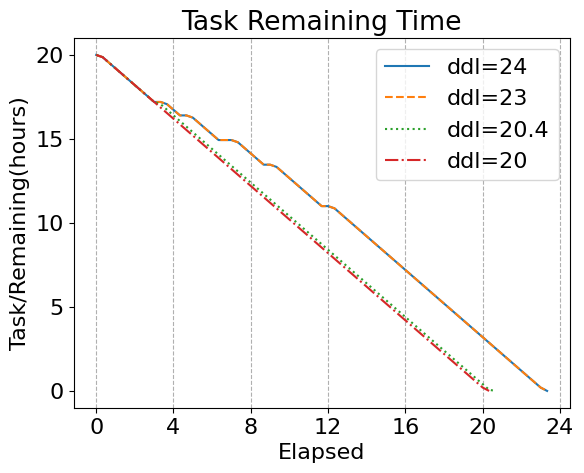

In [8]:
fig, ax = plot_y(run_dfs, y_name='Task/Remaining(hours)', is_step_plot=False)
ax[0].set_title(f'Task Remaining Time')
ax[0].set_xticks(list(range(0, 25, 4)))
ax[0].grid(True, which='major', axis='x', linestyle='--')

## PairAmortizeStrategy

In [9]:
TAGS = []
DDLs = {24}
STRATEGIES = {'strawman', 'pair_amortize'}

run_dfs = filter_runs(TAGS, DDLs, STRATEGIES)
print(len(run_dfs))


4


In [3]:

LINE_STYLES = ['--']
cmap = plt.get_cmap("tab10")
def plot_y(run_dfs, y_name='ClusterType', is_step_plot=True, separate_ax=False, show_detailed_config=True, show_ddl=False):
    if separate_ax:
        fig, ax = plt.subplots(len(run_dfs))
    else:
        fig, ax = plt.subplots()
        ax = [ax] * len(run_dfs)
    strategy, task_duration = None, None
    for i, (run, df) in enumerate(run_dfs):
        config = run.config
        strategy = config['strategy_metadata']['name']
        pair_interval_str = ''
        if 'pair_interval' in config['strategy_metadata'] and show_detailed_config:
            pair_interval = config['strategy_metadata']['pair_interval']
            pair_interval_str = f'+{pair_interval/3600}h'
        use_avg_gain = '+avg' if 'use_avg_gain' in config and config['strategy_metadata']['use_avg_gain'] and show_detailed_config else ''
        ddl = f'{run.config["deadline_hours"]}h'
        label = f'{strategy}{pair_interval_str}{use_avg_gain}'
        if show_ddl and strategy not in ['only_spot', 'on_demand']:
            linestyle='-'
            label += f'({ddl})'
        drawstyle = 'steps-pre' if is_step_plot else None
        linestyle = LINE_STYLES[i%len(LINE_STYLES)] if not separate_ax else '-'
        if strategy in ['only_spot', 'on_demand']:
            linestyle='-'
        sns.lineplot(x=df['Elapsed'] / 3600, y=df[y_name], label=label, 
                    linestyle=linestyle, color=cmap(i), drawstyle=drawstyle, ax=ax[i])
        
        if separate_ax:
            ax[i].set_title(label)
            ax[i].legend().remove()
    if not separate_ax:
        ax[0].legend(loc='best')
    return fig, ax

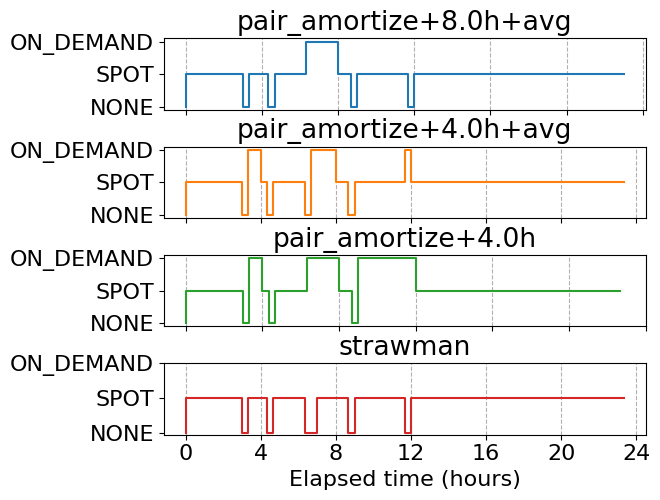

In [11]:
fig, ax = plot_y(run_dfs, y_name='ClusterType', separate_ax=True)
for x in ax:
    x.set_yticks([1, 2, 3])
    x.set_yticklabels([ClusterType(i).name for i in [1, 2, 3]])
    x.set_ylabel('')
    #  ax.set_title(f'')
    x.set_xticks(list(range(0, 25, 4)))
    x.grid(True, which='major', axis='x', linestyle='--')
    x.set_xticklabels([''] * 7)
    x.set_xlabel('')
ax[-1].set_xlabel('Elapsed time (hours)')
ax[-1].set_xticklabels(list(range(0, 25, 4)))
fig.tight_layout(pad=0)

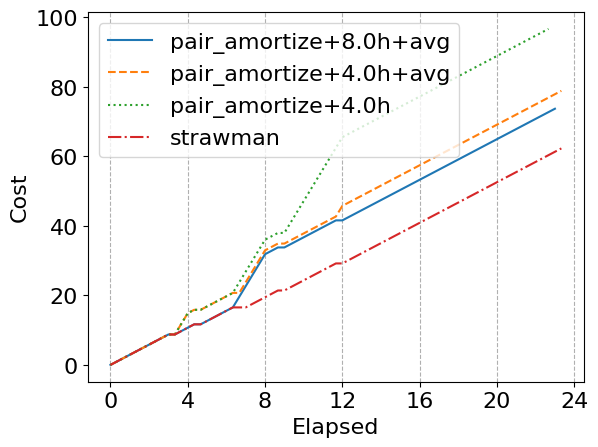

In [12]:
fig, ax = plot_y(run_dfs, y_name='Cost', is_step_plot=False)
ax[0].set_xticks(list(range(0, 25, 4)))
ax[0].grid(True, which='major', axis='x', linestyle='--')

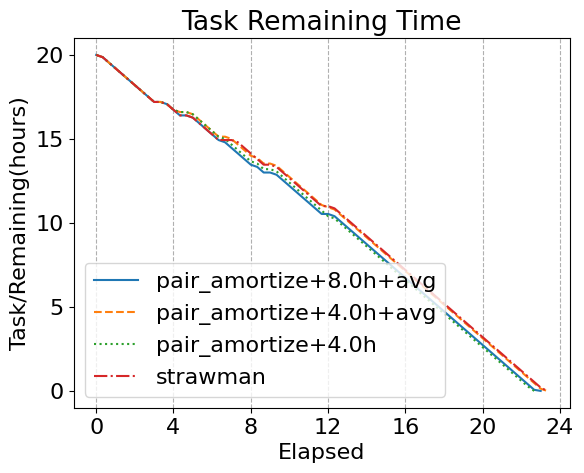

In [13]:
fig, ax = plot_y(run_dfs, y_name='Task/Remaining(hours)', is_step_plot=False)
ax[0].set_title(f'Task Remaining Time')
ax[0].set_xticks(list(range(0, 25, 4)))
ax[0].grid(True, which='major', axis='x', linestyle='--')

In [14]:
TAGS = []
NOT_TAGS = ['hidden']
DDLS = [50, 52]
STRATEGIES = ['only_spot', 'on_demand', 'strawman', 'pair_amortize']
trace_names = ['1.json']
run_dfs = filter_runs(TAGS, DDLS, STRATEGIES, task_durations=[48], trace_names=trace_names)
print(len(run_dfs))
run_dfs = sorted(run_dfs, key=lambda x: STRATEGIES.index(x[0].config['strategy_metadata']['name']))

5


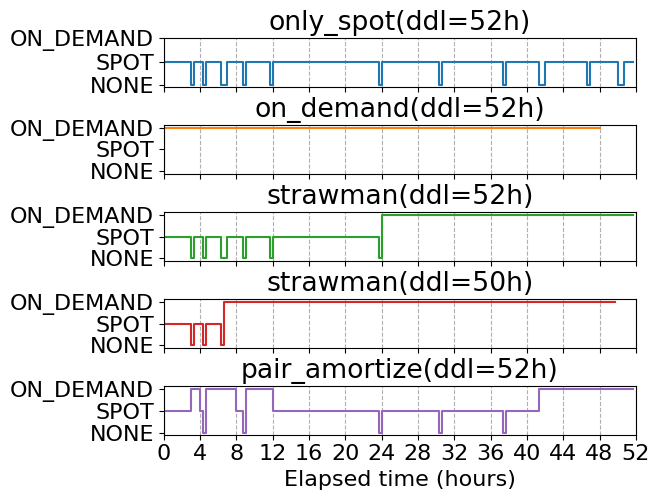

In [15]:
fig, ax = plot_y(run_dfs, y_name='ClusterType', separate_ax=True, show_detailed_config=False, show_ddl=True)
for x in ax:
    x.set_yticks([1, 2, 3])
    x.set_yticklabels([ClusterType(i).name for i in [1, 2, 3]])
    x.set_ylabel('')
    #  ax.set_title(f'')
    x.set_xlim((0, 52))
    x.set_xticks(list(range(0, 53, 4)))
    x.grid(True, which='major', axis='x', linestyle='--')
    x.set_xticklabels([''] * 14)
    x.set_xlabel('')
ax[-1].set_xlabel('Elapsed time (hours)')
ax[-1].set_xticklabels(list(range(0, 53, 4)))
fig.tight_layout(pad=0)

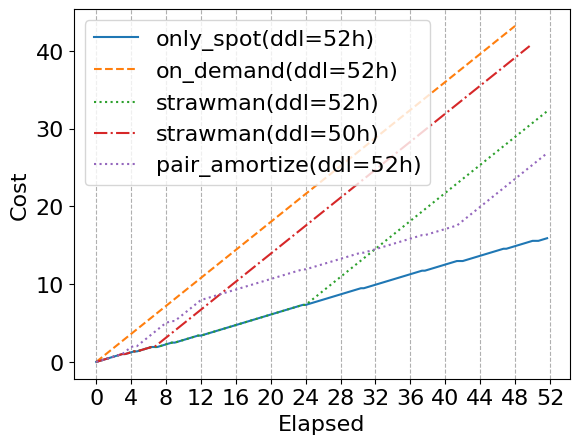

In [16]:
fig, ax = plot_y(run_dfs, y_name='Cost', is_step_plot=False, show_detailed_config=False, show_ddl=True)
ax[0].set_xticks(list(range(0, 53, 4)))
ax[0].grid(True, which='major', axis='x', linestyle='--')

## Real traces

In [17]:
TAGS = []
NOT_TAGS = ['hidden']
DDLS = [52]
STRATEGIES = ['only_spot', 'on_demand', 'strawman', 'pair_amortize']
run_dfs = filter_runs(TAGS, DDLS, STRATEGIES, task_durations=[48], trace_names=['1k80us'])
print(len(run_dfs))
run_dfs = sorted(run_dfs, key=lambda x: STRATEGIES.index(x[0].config['strategy_metadata']['name']))

4


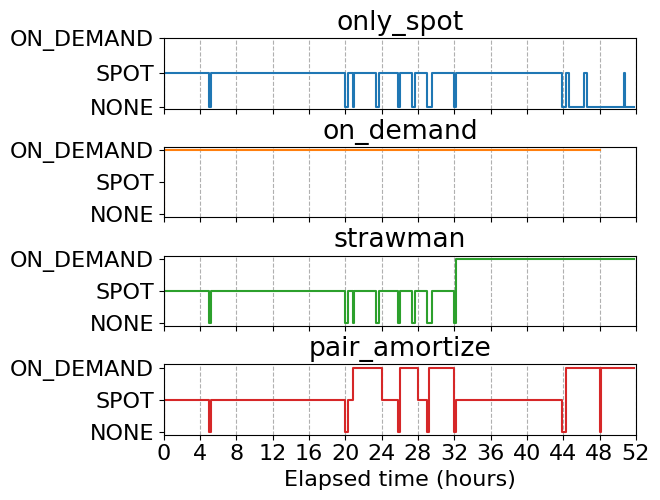

In [18]:
fig, ax = plot_y(run_dfs, y_name='ClusterType', separate_ax=True, show_detailed_config=False)
for x in ax:
    x.set_yticks([1, 2, 3])
    x.set_yticklabels([ClusterType(i).name for i in [1, 2, 3]])
    x.set_ylabel('')
    #  ax.set_title(f'')
    x.set_xlim((0, 52))
    x.set_xticks(list(range(0, 53, 4)))
    x.grid(True, which='major', axis='x', linestyle='--')
    x.set_xticklabels([''] * 14)
    x.set_xlabel('')
ax[-1].set_xlabel('Elapsed time (hours)')
ax[-1].set_xticklabels(list(range(0, 53, 4)))
fig.tight_layout(pad=0)

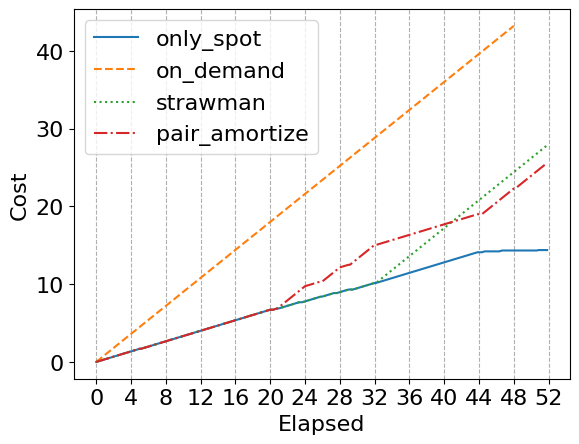

In [19]:
fig, ax = plot_y(run_dfs, y_name='Cost', is_step_plot=False, show_detailed_config=False)
ax[0].set_xticks(list(range(0, 53, 4)))
ax[0].grid(True, which='major', axis='x', linestyle='--')

## No overhead

In [5]:
TAGS = ['no-overhead']
NOT_TAGS = ['hidden']
DDLS = [56, 64, 1000]
STRATEGIES = ['only_spot', 'on_demand', 'strawman']
run_dfs = filter_runs(TAGS, DDLS, STRATEGIES, task_durations=[48], trace_names=['us-west-2a_v100_1'])
print(len(run_dfs))
run_dfs = sorted(run_dfs, key=lambda x: STRATEGIES.index(x[0].config['strategy_metadata']['name']))

4


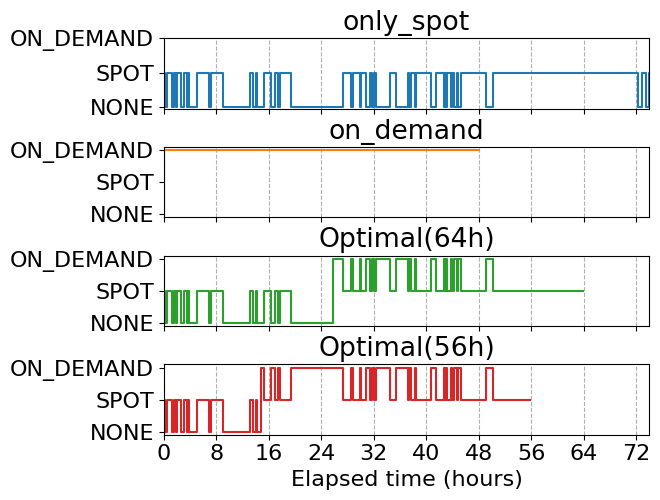

In [7]:
end = 74
tick_range = list(range(0, end, 8))
fig, ax = plot_y(run_dfs, y_name='ClusterType', separate_ax=True, show_detailed_config=False, show_ddl=True)
for x in ax:
    x.set_yticks([1, 2, 3])
    x.set_yticklabels([ClusterType(i).name for i in [1, 2, 3]])
    x.set_ylabel('')
    title = x.get_title()
    if title.startswith('strawman'):
        suffix = title.split('strawman')[1]
        x.set_title(f'Optimal{suffix}')
    #  ax.set_title(f'')
    x.set_xlim((0, end))
    x.set_xticks(tick_range)
    x.grid(True, which='major', axis='x', linestyle='--')
    x.set_xticklabels([''] * len(tick_range))
    x.set_xlabel('')
ax[-1].set_xlabel('Elapsed time (hours)')
ax[-1].set_xticklabels(tick_range)
fig.tight_layout(pad=0)

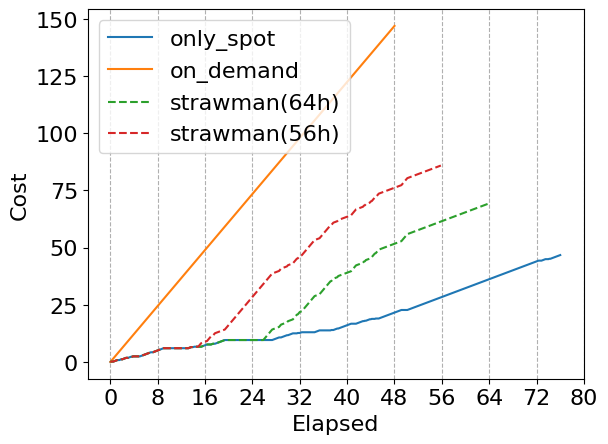

In [8]:
fig, ax = plot_y(run_dfs, y_name='Cost', is_step_plot=False, show_detailed_config=False, show_ddl=True)
ax[0].set_xticks(list(range(0, 81, 8)))
ax[0].grid(True, which='major', axis='x', linestyle='--')

In [91]:
TAGS = ['no-overhead']
NOT_TAGS = ['hidden']
DDLS = [48, 52, 56, 60, 64, 68, 72, 76, 1000]
STRATEGIES = ['strawman', 'on_demand', 'only_spot']
run_dfs = filter_runs(TAGS, DDLS, STRATEGIES, task_durations=[48], trace_names=['us-west-2a_v100_1'])
print(len(run_dfs))
run_dfs = sorted(run_dfs, key=lambda x: STRATEGIES.index(x[0].config['strategy_metadata']['name']))

10


In [92]:
costs = [None] * len(DDLS[:-1])
on_demand_time, on_demand_cost = None, None
spot_time, spot_cost = None, None
for run, df in run_dfs:
    ddl = run.config['deadline_hours']
    strategy = run.config['strategy_metadata']['name']
    if strategy == 'strawman':
        costs[DDLS.index(ddl)] = df['Cost'].values[-1]
    elif strategy == 'on_demand':
        assert on_demand_cost is None
        on_demand_time = df['Elapsed'].values[-1] / 3600
        on_demand_cost = df['Cost'].values[-1]
    elif strategy == 'only_spot':
        assert spot_cost is None
        spot_time = df['Elapsed'].values[-1] / 3600
        spot_cost = df['Cost'].values[-1]
print(costs)

[100.4582, 94.19749999999995, 85.84989999999982, 77.50229999999976, 69.15469999999974, 60.80709999999977, 52.45949999999983, 46.54661666666663]


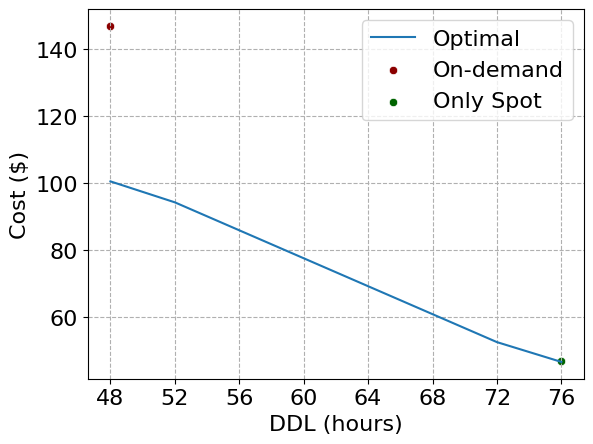

In [93]:
ax = sns.lineplot(x=DDLS[:-1], y=costs, label='Optimal')
ax.set_xticks(DDLS[:-1])
ax.set_xlabel('DDL (hours)')
ax.set_ylabel('Cost ($)')
# on demand
sns.scatterplot(x=[on_demand_time], y=[on_demand_cost], ax=ax, label='On-demand', color='darkred')
sns.scatterplot(x=[spot_time], y=[spot_cost], ax=ax, label='Only Spot', color='darkgreen')
ax.grid(True, linestyle='--')

In [26]:
TAGS = ['overhead=0.1']
NOT_TAGS = ['hidden']
DDLS = [56, 80, 88] + [1000]
STRATEGIES = ['only_spot', 'on_demand', 'ideal_ilp_overhead']
run_dfs = filter_runs(TAGS, DDLS, STRATEGIES, task_durations=[48], trace_names=['us-west-2a_v100_1'])
print(len(run_dfs))
run_dfs = sorted(run_dfs, key=lambda x: STRATEGIES.index(x[0].config['strategy_metadata']['name']))

5


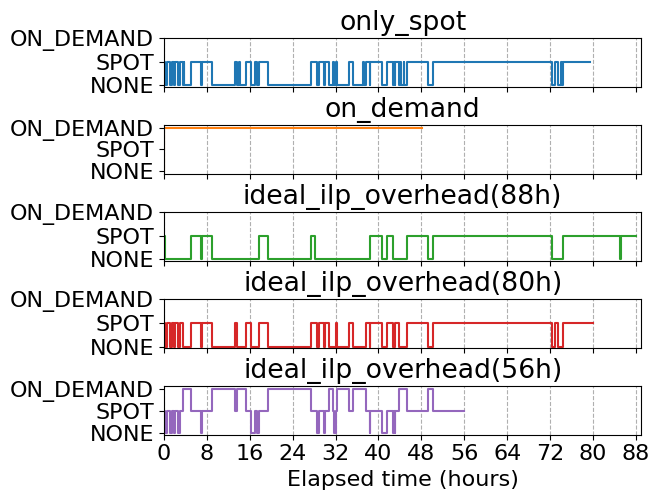

In [27]:
end = 89
tick_range = list(range(0, end, 8))
fig, ax = plot_y(run_dfs, y_name='ClusterType', separate_ax=True, show_detailed_config=False, show_ddl=True)
for x in ax:
    x.set_yticks([1, 2, 3])
    x.set_yticklabels([ClusterType(i).name for i in [1, 2, 3]])
    x.set_ylabel('')
    #  ax.set_title(f'')
    x.set_xlim((0, end))
    x.set_xticks(tick_range)
    x.grid(True, which='major', axis='x', linestyle='--')
    x.set_xticklabels([''] * len(tick_range))
    x.set_xlabel('')
ax[-1].set_xlabel('Elapsed time (hours)')
ax[-1].set_xticklabels(tick_range)
fig.tight_layout(pad=0)

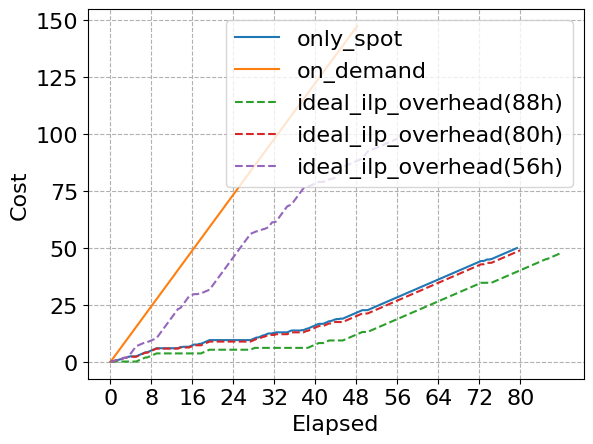

In [28]:
fig, ax = plot_y(run_dfs, y_name='Cost', is_step_plot=False, show_detailed_config=False, show_ddl=True)
ax[0].set_xticks(list(range(0, 81, 8)))
ax[0].grid(True, which='major', linestyle='--')

In [53]:
TAGS = ['no-overhead']
NOT_TAGS = ['hidden']
DDLS = [48, 52, 56, 60, 64, 68, 72, 76]
STRATEGIES = ['strawman']
run_dfs = filter_runs(TAGS, DDLS, STRATEGIES, task_durations=[48], trace_names=['us-west-2a_v100_1'])
print(len(run_dfs))
run_dfs = sorted(run_dfs, key=lambda x: STRATEGIES.index(x[0].config['strategy_metadata']['name']))

no_overhead_costs = []
for run, df in run_dfs:
    ddl = run.config['deadline_hours']
    no_overhead_costs.append((ddl, df['Cost'].values[-1]))

no_overhead_costs = list(zip(*no_overhead_costs))
print(no_overhead_costs)

8
[(76, 72, 68, 64, 60, 56, 52, 48), (46.54661666666663, 52.45949999999983, 60.80709999999977, 69.15469999999974, 77.50229999999976, 85.84989999999982, 94.19749999999995, 100.4582)]


In [87]:
api = wandb.Api()
plt.rc('font', size=16)
entity, project = "michaelvll", "sky-spot"  # set to your entity and project 
runs = api.runs(entity + "/" + project) 

In [73]:
from collections import defaultdict
ideal_costs = defaultdict(list)
only_spot_costs = defaultdict(tuple)

strawman_costs = defaultdict(list)
pair_costs = defaultdict(list)

on_demand_time, on_demand_cost = None, None

def get_costs(overhead: float):
    TAGS = [f'overhead={overhead}']
    NOT_TAGS = ['hidden']
    # DDLS = list(range(48, 93, 4)) + [1000]
    # DDLS[0] = 48.1
    DDLS = None
    STRATEGIES = ['ideal_ilp_overhead', 'strawman', 'on_demand', 'pair_amortize', 'only_spot']
    run_dfs = filter_runs(TAGS, DDLS, STRATEGIES, task_durations=[48], trace_names=['us-west-2a_v100_1'])

    print(len(run_dfs))
    run_dfs = sorted(run_dfs, key=lambda x: STRATEGIES.index(x[0].config['strategy_metadata']['name']))
    for run, df in run_dfs:
        ddl = run.config['deadline_hours']
        strategy = run.config['strategy_metadata']['name']
        if strategy == 'ideal_ilp_overhead':
            ideal_costs[overhead].append((ddl, df['Cost'].values[-1]))
        elif strategy == 'strawman':
            strawman_costs[overhead].append((ddl, df['Cost'].values[-1]))
        elif strategy == 'pair_amortize':
            pair_costs[overhead].append((ddl, df['Cost'].values[-1]))
        elif strategy == 'on_demand':
            on_demand_time = df['Elapsed'].values[-1] / 3600
            on_demand_cost = df['Cost'].values[-1]
        elif strategy == 'only_spot':
            assert overhead not in only_spot_costs
            only_spot_costs[overhead] = (df['Elapsed'].values[-1] / 3600, df['Cost'].values[-1])
    ideal_costs[overhead] = list(zip(*ideal_costs[overhead]))
    print(ideal_costs[overhead])
    if overhead in strawman_costs:
        strawman_costs[overhead] = list(zip(*strawman_costs[overhead]))
        print(strawman_costs[overhead])
    if overhead in pair_costs:
        pair_costs[overhead] = list(zip(*pair_costs[overhead]))
        print(pair_costs[overhead])

get_costs(0.1)
get_costs(0.01)
get_costs(0.05)
get_costs(0.15)

42
[(92, 88, 84, 80, 76, 72, 68, 64, 60, 56, 52, 51, 50, 49, 48.5, 48.2, 48.1), (47.51971666666662, 47.84408333333328, 48.16844999999994, 48.9793666666666, 56.908799999999815, 61.80168333333304, 70.49709999999963, 79.19251666666634, 88.37448333333307, 97.95116666666658, 109.24348333333337, 113.97418333333346, 119.95741666666693, 126.63628333333375, 136.93205000000037, 141.29148333333367, 147.3900000000002)]
[(92, 88, 84, 80, 76, 72, 68, 64, 60, 56, 52, 48.1), (49.95246666666659, 49.95246666666659, 49.95246666666659, 49.95246666666659, 115.2032666666671, 123.43558333333384, 125.7081166666672, 130.94881666666717, 130.94881666666717, 137.07078333333374, 137.07078333333374, 147.3900000000002)]
[(92, 88, 84, 80, 76, 72, 68, 64, 60, 56, 52), (68.06238333333303, 73.99871666666633, 73.99871666666633, 86.70574999999963, 86.70574999999963, 98.69369999999984, 98.69369999999984, 108.61820000000002, 136.30480000000037, 141.03550000000027, 144.02711666666693)]
18
[(92, 88, 84, 77, 76, 72, 68, 64, 60

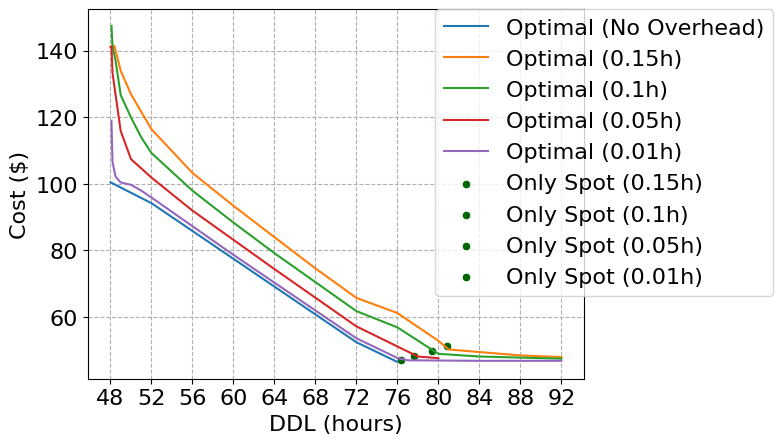

In [74]:
ax = sns.lineplot(x=no_overhead_costs[0], y=no_overhead_costs[1], label='Optimal (No Overhead)')
ax = sns.lineplot(x=ideal_costs[0.15][0], y=ideal_costs[0.15][1], label='Optimal (0.15h)')
ax = sns.lineplot(x=ideal_costs[0.1][0], y=ideal_costs[0.1][1], label='Optimal (0.1h)')
ax = sns.lineplot(x=ideal_costs[0.05][0], y=ideal_costs[0.05][1], label='Optimal (0.05h)')
ax = sns.lineplot(x=ideal_costs[0.01][0], y=ideal_costs[0.01][1], label='Optimal (0.01h)')
# ax = sns.lineplot(x=strawman_costs[0], y=strawman_costs[1], label='Strawman (With Overhead=0.1)')
# ax = sns.lineplot(x=pair_costs[0], y=pair_costs[1], label='Pair Amortize (With Overhead=0.1)')
ax.set_xticks(list(range(48, 153, 4)))
ax.set_xlabel('DDL (hours)')
ax.set_ylabel('Cost ($)')
# on demand
sns.scatterplot(x=[on_demand_time], y=[on_demand_cost], ax=ax, label='On-demand', color='darkred')
sns.scatterplot(x=[only_spot_costs[0.15][0]], y=[only_spot_costs[0.15][1]], ax=ax, label='Only Spot (0.15h)', color='darkgreen')
sns.scatterplot(x=[only_spot_costs[0.1][0]], y=[only_spot_costs[0.1][1]], ax=ax, label='Only Spot (0.1h)', color='darkgreen')
sns.scatterplot(x=[only_spot_costs[0.05][0]], y=[only_spot_costs[0.05][1]], ax=ax, label='Only Spot (0.05h)', color='darkgreen')
sns.scatterplot(x=[only_spot_costs[0.01][0]], y=[only_spot_costs[0.01][1]], ax=ax, label='Only Spot (0.01h)', color='darkgreen')
ax.grid(True, linestyle='--')
ax.legend(loc='upper left', bbox_to_anchor=(0.7, 1), borderaxespad=0)

5


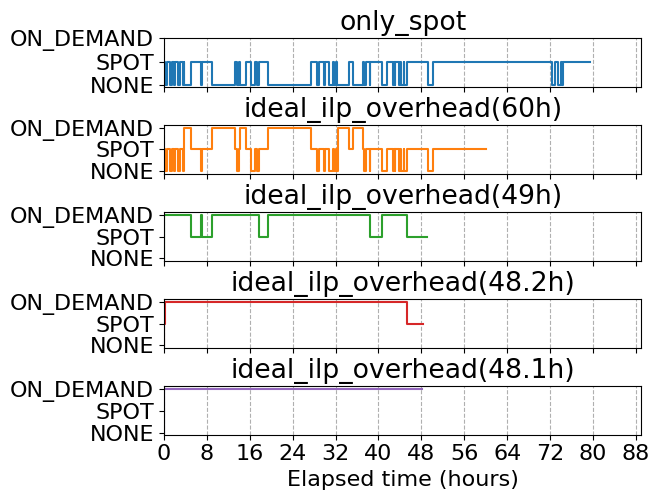

In [85]:
TAGS = ['overhead=0.1']
NOT_TAGS = ['hidden']
DDLS = [48.1, 48.2, 49, 60, 1000]
STRATEGIES = ['only_spot', 'ideal_ilp_overhead']
run_dfs = filter_runs(TAGS, DDLS, STRATEGIES, task_durations=[48], trace_names=['us-west-2a_v100_1'])
print(len(run_dfs))
run_dfs = sorted(run_dfs, key=lambda x: STRATEGIES.index(x[0].config['strategy_metadata']['name']))

end = 89
tick_range = list(range(0, end, 8))
fig, ax = plot_y(run_dfs, y_name='ClusterType', separate_ax=True, show_detailed_config=False, show_ddl=True)
for x in ax:
    x.set_yticks([1, 2, 3])
    x.set_yticklabels([ClusterType(i).name for i in [1, 2, 3]])
    x.set_ylabel('')
    #  ax.set_title(f'')
    x.set_xlim((0, end))
    x.set_xticks(tick_range)
    x.grid(True, which='major', axis='x', linestyle='--')
    x.set_xticklabels([''] * len(tick_range))
    x.set_xlabel('')
ax[-1].set_xlabel('Elapsed time (hours)')
ax[-1].set_xticklabels(tick_range)

fig.tight_layout(pad=0)

5


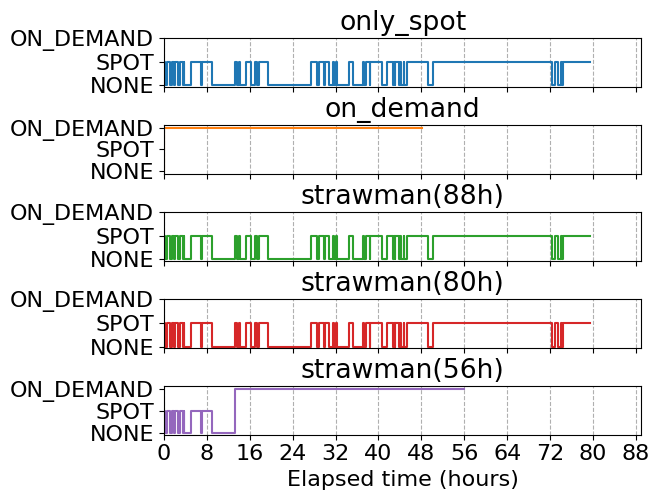

In [56]:
TAGS = ['overhead=0.1']
NOT_TAGS = ['hidden']
DDLS = [56, 80, 88] + [1000]
STRATEGIES = ['only_spot', 'on_demand', 'strawman']
run_dfs = filter_runs(TAGS, DDLS, STRATEGIES, task_durations=[48], trace_names=['us-west-2a_v100_1'])
print(len(run_dfs))
run_dfs = sorted(run_dfs, key=lambda x: STRATEGIES.index(x[0].config['strategy_metadata']['name']))

end = 89
tick_range = list(range(0, end, 8))
fig, ax = plot_y(run_dfs, y_name='ClusterType', separate_ax=True, show_detailed_config=False, show_ddl=True)
for x in ax:
    x.set_yticks([1, 2, 3])
    x.set_yticklabels([ClusterType(i).name for i in [1, 2, 3]])
    x.set_ylabel('')
    #  ax.set_title(f'')
    x.set_xlim((0, end))
    x.set_xticks(tick_range)
    x.grid(True, which='major', axis='x', linestyle='--')
    x.set_xticklabels([''] * len(tick_range))
    x.set_xlabel('')
ax[-1].set_xlabel('Elapsed time (hours)')
ax[-1].set_xticklabels(tick_range)
fig.tight_layout(pad=0)

5


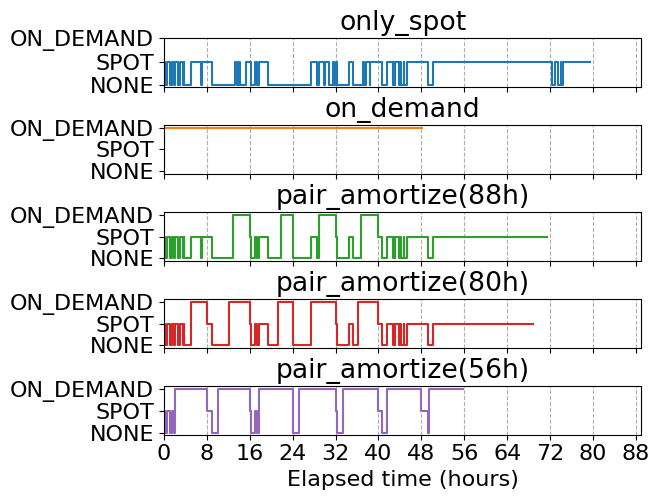

In [57]:
TAGS = ['overhead=0.1']
NOT_TAGS = ['hidden']
DDLS = [56, 80, 88] + [1000]
STRATEGIES = ['only_spot', 'on_demand', 'pair_amortize']
run_dfs = filter_runs(TAGS, DDLS, STRATEGIES, task_durations=[48], trace_names=['us-west-2a_v100_1'])
print(len(run_dfs))
run_dfs = sorted(run_dfs, key=lambda x: STRATEGIES.index(x[0].config['strategy_metadata']['name']))

end = 89
tick_range = list(range(0, end, 8))
fig, ax = plot_y(run_dfs, y_name='ClusterType', separate_ax=True, show_detailed_config=False, show_ddl=True)
for x in ax:
    x.set_yticks([1, 2, 3])
    x.set_yticklabels([ClusterType(i).name for i in [1, 2, 3]])
    x.set_ylabel('')
    #  ax.set_title(f'')
    x.set_xlim((0, end))
    x.set_xticks(tick_range)
    x.grid(True, which='major', axis='x', linestyle='--')
    x.set_xticklabels([''] * len(tick_range))
    x.set_xlabel('')
ax[-1].set_xlabel('Elapsed time (hours)')
ax[-1].set_xticklabels(tick_range)
fig.tight_layout(pad=0)

## Start 72h

4


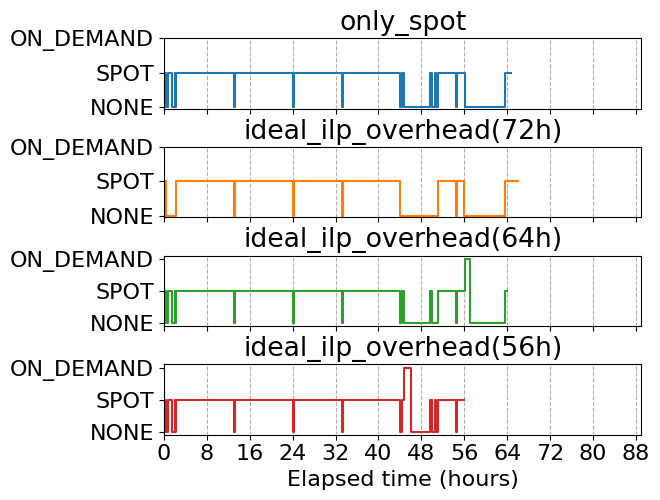

In [145]:
TAGS = ['overhead=0.1', 'start=72h']
NOT_TAGS = ['hidden']
DDLS = [56, 64, 72] + [1000]
STRATEGIES = ['only_spot', 'on_demand', 'ideal_ilp_overhead']
run_dfs = filter_runs(TAGS, DDLS, STRATEGIES, task_durations=[48], trace_names=['us-west-2a_v100_1'])
print(len(run_dfs))
run_dfs = sorted(run_dfs, key=lambda x: STRATEGIES.index(x[0].config['strategy_metadata']['name']))

end = 89
tick_range = list(range(0, end, 8))
fig, ax = plot_y(run_dfs, y_name='ClusterType', separate_ax=True, show_detailed_config=False, show_ddl=True)
for x in ax:
    x.set_yticks([1, 2, 3])
    x.set_yticklabels([ClusterType(i).name for i in [1, 2, 3]])
    x.set_ylabel('')
    #  ax.set_title(f'')
    x.set_xlim((0, end))
    x.set_xticks(tick_range)
    x.grid(True, which='major', axis='x', linestyle='--')
    x.set_xticklabels([''] * len(tick_range))
    x.set_xlabel('')
ax[-1].set_xlabel('Elapsed time (hours)')
ax[-1].set_xticklabels(tick_range)
fig.tight_layout(pad=0)

In [139]:
api = wandb.Api()
plt.rc('font', size=16)
entity, project = "michaelvll", "sky-spot"  # set to your entity and project 
runs = api.runs(entity + "/" + project) 

In [140]:
TAGS = ['no-overhead', 'start=72h']
NOT_TAGS = ['hidden']
DDLS = None
STRATEGIES = ['ideal_no_overhead']
run_dfs = filter_runs(TAGS, DDLS, STRATEGIES, task_durations=[48], trace_names=['us-west-2a_v100_1'])
print(len(run_dfs))
run_dfs = sorted(run_dfs, key=lambda x: STRATEGIES.index(x[0].config['strategy_metadata']['name']))

no_overhead_costs = []
for run, df in run_dfs:
    ddl = run.config['deadline_hours']
    no_overhead_costs.append((ddl, df['Cost'].values[-1]))

no_overhead_costs = list(zip(*no_overhead_costs))
print(no_overhead_costs)

7
[(72, 68, 64, 60, 56, 52, 48), (46.70879999999996, 46.70879999999996, 46.70879999999996, 46.70879999999996, 46.70879999999996, 54.70858333333325, 57.83893333333325)]


In [141]:
from collections import defaultdict
ideal_costs = defaultdict(list)
only_spot_costs = defaultdict(tuple)

strawman_costs = defaultdict(list)
pair_costs = defaultdict(list)

on_demand_time, on_demand_cost = None, None

def get_costs(overhead: float):
    TAGS = [f'overhead={overhead}', 'start=72h']
    NOT_TAGS = ['hidden']
    # DDLS = list(range(48, 93, 4)) + [1000]
    # DDLS[0] = 48.1
    DDLS = None
    STRATEGIES = ['ideal_ilp_overhead', 'strawman', 'on_demand', 'pair_amortize', 'only_spot']
    run_dfs = filter_runs(TAGS, DDLS, STRATEGIES, task_durations=[48], trace_names=['us-west-2a_v100_1'])

    print(len(run_dfs))
    run_dfs = sorted(run_dfs, key=lambda x: STRATEGIES.index(x[0].config['strategy_metadata']['name']))
    for run, df in run_dfs:
        ddl = run.config['deadline_hours']
        strategy = run.config['strategy_metadata']['name']
        if strategy == 'ideal_ilp_overhead':
            ideal_costs[overhead].append((ddl, df['Cost'].values[-1]))
        elif strategy == 'strawman':
            strawman_costs[overhead].append((ddl, df['Cost'].values[-1]))
        elif strategy == 'pair_amortize':
            pair_costs[overhead].append((ddl, df['Cost'].values[-1]))
        elif strategy == 'on_demand':
            on_demand_time = df['Elapsed'].values[-1] / 3600
            on_demand_cost = df['Cost'].values[-1]
        elif strategy == 'only_spot':
            assert overhead not in only_spot_costs, (overhead, only_spot_costs)
            only_spot_costs[overhead] = (df['Elapsed'].values[-1] / 3600, df['Cost'].values[-1])
    ideal_costs[overhead] = list(zip(*ideal_costs[overhead]))
    print(ideal_costs[overhead])
    if overhead in strawman_costs:
        strawman_costs[overhead] = list(zip(*strawman_costs[overhead]))
        print(strawman_costs[overhead])
    if overhead in pair_costs:
        pair_costs[overhead] = list(zip(*pair_costs[overhead]))
        print(pair_costs[overhead])

get_costs(0.1)
# get_costs(0.01)
# get_costs(0.05)
get_costs(0.15)

31
[(72, 68, 65, 64, 60, 56, 52, 51, 50, 49, 48.8, 48.5, 48.2, 48.1), (47.51971666666662, 47.51971666666662, 47.68189999999995, 49.745349999999945, 50.44098333333328, 50.788799999999945, 58.78858333333328, 60.73674999999995, 61.06111666666658, 63.333649999999885, 81.60575000000004, 103.54165, 125.29191666666712, 147.3900000000002)]
[(76, 72, 68, 64, 60, 56, 52, 51, 50, 49, 48.5, 48.2), (48.00626666666661, 48.00626666666661, 48.00626666666661, 50.44098333333328, 50.44098333333328, 60.89893333333328, 60.89893333333328, 60.89893333333328, 101.61693333333366, 145.81310000000025, 147.20436666666689, 147.20436666666689)]
[(80, 72, 64, 56), (48.00626666666661, 49.21189999999994, 50.44098333333328, 73.04906666666656)]
14
[(76, 72, 68, 66, 64, 60, 56, 52, 51, 50, 49, 48.5, 48.2), (48.00626666666661, 48.16844999999994, 48.16844999999994, 48.16844999999994, 51.623166666666606, 52.15661666666661, 52.504433333333274, 60.342033333333276, 62.428933333333255, 62.77674999999991, 103.86601666666705, 125

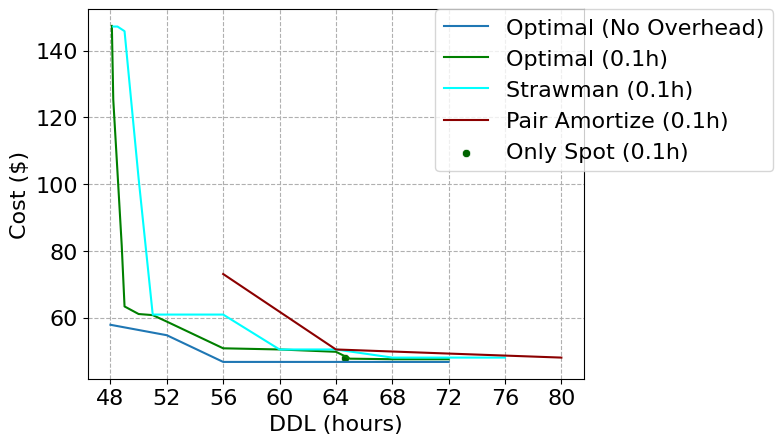

In [153]:
ax = sns.lineplot(x=no_overhead_costs[0], y=no_overhead_costs[1], label='Optimal (No Overhead)')
# ax = sns.lineplot(x=ideal_costs[0.15][0], y=ideal_costs[0.15][1], label='Optimal (0.15h)')
ax = sns.lineplot(x=ideal_costs[0.1][0], y=ideal_costs[0.1][1], label='Optimal (0.1h)', color='green')
# ax = sns.lineplot(x=ideal_costs[0.05][0], y=ideal_costs[0.05][1], label='Optimal (0.05h)')
# ax = sns.lineplot(x=ideal_costs[0.01][0], y=ideal_costs[0.01][1], label='Optimal (0.01h)')
ax = sns.lineplot(x=strawman_costs[0.1][0], y=strawman_costs[0.1][1], label='Strawman (0.1h)', color='cyan')
ax = sns.lineplot(x=pair_costs[0.1][0], y=pair_costs[0.1][1], label='Pair Amortize (0.1h)', color='darkred')
ax.set_xticks(list(range(48, 153, 4)))
ax.set_xlabel('DDL (hours)')
ax.set_ylabel('Cost ($)')
# on demand
sns.scatterplot(x=[on_demand_time], y=[on_demand_cost], ax=ax, label='On-demand', color='darkred')
# sns.scatterplot(x=[only_spot_costs[0.15][0]], y=[only_spot_costs[0.15][1]], ax=ax, label='Only Spot (0.15h)', color='darkgreen')
sns.scatterplot(x=[only_spot_costs[0.1][0]], y=[only_spot_costs[0.1][1]], ax=ax, label='Only Spot (0.1h)', color='darkgreen')
# sns.scatterplot(x=[only_spot_costs[0.05][0]], y=[only_spot_costs[0.05][1]], ax=ax, label='Only Spot (0.05h)', color='darkgreen')
# sns.scatterplot(x=[only_spot_costs[0.01][0]], y=[only_spot_costs[0.01][1]], ax=ax, label='Only Spot (0.01h)', color='darkgreen')
ax.grid(True, linestyle='--')
ax.legend(loc='upper left', bbox_to_anchor=(0.7, 1), borderaxespad=0)

4


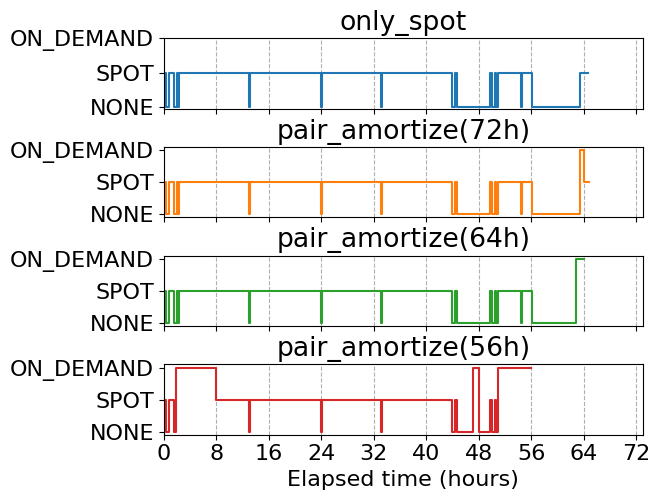

In [148]:
TAGS = ['overhead=0.1', 'start=72h']
NOT_TAGS = ['hidden']
DDLS = [56, 64, 72] + [1000]
STRATEGIES = ['only_spot', 'pair_amortize']
run_dfs = filter_runs(TAGS, DDLS, STRATEGIES, task_durations=[48], trace_names=['us-west-2a_v100_1'])
print(len(run_dfs))
run_dfs = sorted(run_dfs, key=lambda x: STRATEGIES.index(x[0].config['strategy_metadata']['name']))

end = 73
tick_range = list(range(0, end, 8))
fig, ax = plot_y(run_dfs, y_name='ClusterType', separate_ax=True, show_detailed_config=False, show_ddl=True)
for x in ax:
    x.set_yticks([1, 2, 3])
    x.set_yticklabels([ClusterType(i).name for i in [1, 2, 3]])
    x.set_ylabel('')
    #  ax.set_title(f'')
    x.set_xlim((0, end))
    x.set_xticks(tick_range)
    x.grid(True, which='major', axis='x', linestyle='--')
    x.set_xticklabels([''] * len(tick_range))
    x.set_xlabel('')
ax[-1].set_xlabel('Elapsed time (hours)')
ax[-1].set_xticklabels(tick_range)
fig.tight_layout(pad=0)